# Decision Tree Runtime Complexity Experiments

This notebook analyzes the runtime complexity of our custom Decision Tree implementation across different data types and configurations.

## Objectives:
- Measure training and prediction time complexity
- Test all 4 combinations of input/output types
- Compare empirical results with theoretical expectations
- Generate performance plots and analysis

## Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
num_average_time = 1  # Only 1 run per configuration for speed

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Generation Functions

In [2]:
def create_fake_data(N, M, case_type):
    """
    Create fake data for different decision tree cases
    
    Parameters:
    N: number of samples
    M: number of features
    case_type: string indicating the type of DT case
        - "discrete_input_discrete_output": All features are discrete, output is discrete
        - "discrete_input_real_output": All features are discrete, output is real
        - "real_input_discrete_output": All features are real, output is discrete  
        - "real_input_real_output": All features are real, output is real
    
    Returns:
    X: Feature matrix (N x M)
    y: Target vector (N,)
    """
    
    if case_type == "discrete_input_discrete_output":
        # Binary features (0 or 1)
        X = np.random.randint(0, 2, size=(N, M))
        # Binary classification (0 or 1)
        y = np.random.randint(0, 2, size=N)
        
    elif case_type == "discrete_input_real_output":
        # Binary features (0 or 1)
        X = np.random.randint(0, 2, size=(N, M))
        # Continuous target (regression)
        y = np.random.normal(0, 1, size=N)
        
    elif case_type == "real_input_discrete_output":
        # Use fewer unique values for real features to speed up split finding
        X = np.round(np.random.normal(0, 1, size=(N, M)), 1)  # Round to 1 decimal place
        # Binary classification (0 or 1)
        y = np.random.randint(0, 2, size=N)
        
    elif case_type == "real_input_real_output":
        # Use fewer unique values for real features to speed up split finding
        X = np.round(np.random.normal(0, 1, size=(N, M)), 1)  # Round to 1 decimal place
        # Continuous target (regression)
        y = np.random.normal(0, 1, size=N)
        
    else:
        raise ValueError("Invalid case_type")
    
    # Convert to DataFrame
    feature_names = [f'feature_{i}' for i in range(M)]
    X_df = pd.DataFrame(X, columns=feature_names)
    y_series = pd.Series(y, name='target')
    
    return X_df, y_series

print("Data generation function defined!")

Data generation function defined!


## Time Complexity Measurement Function

In [3]:
def measure_time_complexity(case_type, N_values, M_values, max_depth=2):
    """
    Measure average time taken for fit() and predict() for different N and M values
    
    Parameters:
    case_type: string indicating the DT case type
    N_values: list of sample sizes to test
    M_values: list of feature counts to test  
    max_depth: maximum depth of the decision tree
    
    Returns:
    results: dictionary containing timing results
    """
    
    print(f"\nMEASURING TIME COMPLEXITY FOR: {case_type.upper()}")
    
    results = {
        'case_type': case_type,
        'N_values': N_values,
        'M_values': M_values,
        'fit_times_vs_N': [],
        'predict_times_vs_N': [],
        'fit_times_vs_M': [],
        'predict_times_vs_M': [],
        'fit_std_vs_N': [],
        'predict_std_vs_N': [],
        'fit_std_vs_M': [],
        'predict_std_vs_M': []
    }
    
    # Determine if this is a regression case
    is_regression = case_type.endswith("real_output")
    criterion = "mse" if is_regression else "information_gain"
    
    print(f"Case: {case_type}")
    print(f"Is Regression: {is_regression}")
    print(f"Criterion: {criterion}")
    
    # Test 1: Vary N (number of samples), keep M fixed
    print(f"\nTest 1: Varying N (samples) with M=10 features")
    M_fixed = 10
    fit_times_N = []
    predict_times_N = []
    fit_stds_N = []
    predict_stds_N = []
    
    for N in N_values:
        print(f"  Testing N={N}...", end="", flush=True)
        
        fit_times_runs = []
        predict_times_runs = []
        
        for run in range(num_average_time):
            try:
                # Create data
                X_train, y_train = create_fake_data(N, M_fixed, case_type)
                X_test, y_test = create_fake_data(max(50, N//5), M_fixed, case_type)
                
                # Create decision tree
                dt = DecisionTree(criterion=criterion, max_depth=max_depth)
                
                # Measure fit time
                start_time = time.time()
                dt.fit(X_train, y_train)
                fit_time = time.time() - start_time
                fit_times_runs.append(fit_time)
                
                # Measure predict time
                start_time = time.time()
                predictions = dt.predict(X_test)
                predict_time = time.time() - start_time
                predict_times_runs.append(predict_time)
            except Exception as e:
                print(f"\n    Warning: Run {run+1} failed for N={N}: {str(e)}")
                continue
        
        avg_fit_time = np.mean(fit_times_runs)
        std_fit_time = np.std(fit_times_runs)
        avg_predict_time = np.mean(predict_times_runs)
        std_predict_time = np.std(predict_times_runs)
        
        fit_times_N.append(avg_fit_time)
        predict_times_N.append(avg_predict_time)
        fit_stds_N.append(std_fit_time)
        predict_stds_N.append(std_predict_time)
        
        print(f" Fit: {avg_fit_time:.4f}±{std_fit_time:.4f}s, Predict: {avg_predict_time:.4f}±{std_predict_time:.4f}s")
    
    results['fit_times_vs_N'] = fit_times_N
    results['predict_times_vs_N'] = predict_times_N
    results['fit_std_vs_N'] = fit_stds_N
    results['predict_std_vs_N'] = predict_stds_N
    
    # Test 2: Vary M (number of features), keep N fixed
    print(f"\nTest 2: Varying M (features) with N=1000 samples")
    N_fixed = 1000
    fit_times_M = []
    predict_times_M = []
    fit_stds_M = []
    predict_stds_M = []
    
    for M in M_values:
        print(f"  Testing M={M}...", end="")
        
        fit_times_runs = []
        predict_times_runs = []
        
        for run in range(num_average_time):
            # Create data
            X_train, y_train = create_fake_data(N_fixed, M, case_type)
            X_test, y_test = create_fake_data(200, M, case_type)
            
            # Create decision tree
            dt = DecisionTree(criterion=criterion, max_depth=max_depth)
            
            # Measure fit time
            start_time = time.time()
            dt.fit(X_train, y_train)
            fit_time = time.time() - start_time
            fit_times_runs.append(fit_time)
            
            # Measure predict time
            start_time = time.time()
            predictions = dt.predict(X_test)
            predict_time = time.time() - start_time
            predict_times_runs.append(predict_time)
        
        avg_fit_time = np.mean(fit_times_runs)
        std_fit_time = np.std(fit_times_runs)
        avg_predict_time = np.mean(predict_times_runs)
        std_predict_time = np.std(predict_times_runs)
        
        fit_times_M.append(avg_fit_time)
        predict_times_M.append(avg_predict_time)
        fit_stds_M.append(std_fit_time)
        predict_stds_M.append(std_predict_time)
        
        print(f" Fit: {avg_fit_time:.4f}±{std_fit_time:.4f}s, Predict: {avg_predict_time:.4f}±{std_predict_time:.4f}s")
    
    results['fit_times_vs_M'] = fit_times_M
    results['predict_times_vs_M'] = predict_times_M
    results['fit_std_vs_M'] = fit_stds_M
    results['predict_std_vs_M'] = predict_stds_M
    
    return results

print("Time measurement function defined!")

Time measurement function defined!


## Plotting Functions

In [4]:
def plot_complexity_results(all_results, N_values, M_values):
    """
    Plot the time complexity results for all cases
    """
    
    cases = list(all_results.keys())
    
    # Create plots for N variation (fit and predict)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Decision Tree Time Complexity Analysis', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green', 'orange']
    markers = ['o', 's', '^', 'D']
    
    # Plot 1: Fit time vs N
    ax = axes[0, 0]
    for i, case in enumerate(cases):
        results = all_results[case]
        ax.errorbar(N_values, results['fit_times_vs_N'], 
                   yerr=results['fit_std_vs_N'],
                   label=case.replace('_', ' ').title(),
                   color=colors[i], marker=markers[i], 
                   linewidth=2, markersize=6, capsize=5)
    
    ax.set_xlabel('Number of Samples (N)')
    ax.set_ylabel('Training Time (seconds)')
    ax.set_title('Training Time vs Number of Samples')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot 2: Predict time vs N  
    ax = axes[0, 1]
    for i, case in enumerate(cases):
        results = all_results[case]
        ax.errorbar(N_values, results['predict_times_vs_N'],
                   yerr=results['predict_std_vs_N'], 
                   label=case.replace('_', ' ').title(),
                   color=colors[i], marker=markers[i],
                   linewidth=2, markersize=6, capsize=5)
    
    ax.set_xlabel('Number of Samples (N)')
    ax.set_ylabel('Prediction Time (seconds)')
    ax.set_title('Prediction Time vs Number of Samples')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot 3: Fit time vs M
    ax = axes[1, 0]
    for i, case in enumerate(cases):
        results = all_results[case]
        ax.errorbar(M_values, results['fit_times_vs_M'],
                   yerr=results['fit_std_vs_M'],
                   label=case.replace('_', ' ').title(),
                   color=colors[i], marker=markers[i],
                   linewidth=2, markersize=6, capsize=5)
    
    ax.set_xlabel('Number of Features (M)')
    ax.set_ylabel('Training Time (seconds)')
    ax.set_title('Training Time vs Number of Features')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Predict time vs M
    ax = axes[1, 1]
    for i, case in enumerate(cases):
        results = all_results[case]
        ax.errorbar(M_values, results['predict_times_vs_M'],
                   yerr=results['predict_std_vs_M'],
                   label=case.replace('_', ' ').title(), 
                   color=colors[i], marker=markers[i],
                   linewidth=2, markersize=6, capsize=5)
    
    ax.set_xlabel('Number of Features (M)')
    ax.set_ylabel('Prediction Time (seconds)')
    ax.set_title('Prediction Time vs Number of Features')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Plotting function defined!")

Plotting function defined!


## Theoretical Analysis Function

In [5]:
def analyze_theoretical_complexity(all_results, N_values, M_values):
    """
    Analyze and compare with theoretical time complexity
    """
    
    print("\nTHEORETICAL COMPLEXITY ANALYSIS")
    
    print("\nTHEORETICAL EXPECTATIONS:")
    print("1. Training Time Complexity:")
    print("   - Best case: O(N * M * log(N))  [balanced tree]")
    print("   - Worst case: O(N * M * N)      [degenerate tree]")
    print("   - Average case: O(N * M * log(N))")
    print("\n2. Prediction Time Complexity:")
    print("   - Best case: O(log(N))          [balanced tree]")
    print("   - Worst case: O(N)              [degenerate tree]")
    print("   - Average case: O(log(N))")
    
    print("\nEMPIRICAL ANALYSIS")
    
    for case_type, results in all_results.items():
        print(f"\nCase: {case_type.upper()}")
        
        # Analyze fit time scaling with N
        fit_times_N = np.array(results['fit_times_vs_N'])
        N_array = np.array(N_values)
        
        # Calculate growth rates
        if len(fit_times_N) > 1:
            # Log-linear fit for fit time vs N
            log_N = np.log(N_array)
            log_fit_times = np.log(fit_times_N)
            
            # Linear regression to find scaling
            A = np.vstack([log_N, np.ones(len(log_N))]).T
            slope_N, intercept_N = np.linalg.lstsq(A, log_fit_times, rcond=None)[0]
            
            print(f"Training Time Scaling with N:")
            print(f"  Empirical scaling: O(N^{slope_N:.2f})")
            print(f"  Expected: O(N * log(N)) ≈ O(N^1.0 to N^1.3)")
            
            if slope_N < 1.5:
                print(f"Good scaling - close to expected O(N log N)")
            else:
                print(f"Higher than expected - may indicate suboptimal implementation")
        
        # Analyze predict time scaling with N  
        predict_times_N = np.array(results['predict_times_vs_N'])
        
        if len(predict_times_N) > 1:
            log_predict_times = np.log(predict_times_N)
            slope_predict_N, intercept_predict_N = np.linalg.lstsq(A, log_predict_times, rcond=None)[0]
            
            print(f"Prediction Time Scaling with N:")
            print(f"  Empirical scaling: O(N^{slope_predict_N:.2f})")
            print(f"  Expected: O(log(N)) ≈ O(N^0.0 to N^0.3)")
            
            if slope_predict_N < 0.5:
                print(f"Good scaling - close to expected O(log N)")
            else:
                print(f"Higher than expected - prediction may be linear in training size")
        
        # Analyze fit time scaling with M
        fit_times_M = np.array(results['fit_times_vs_M'])
        M_array = np.array(M_values)
        
        if len(fit_times_M) > 1:
            log_M = np.log(M_array)
            log_fit_times_M = np.log(fit_times_M)
            
            A_M = np.vstack([log_M, np.ones(len(log_M))]).T
            slope_M, intercept_M = np.linalg.lstsq(A_M, log_fit_times_M, rcond=None)[0]
            
            print(f"Training Time Scaling with M:")
            print(f"  Empirical scaling: O(M^{slope_M:.2f})")
            print(f"  Expected: O(M) ≈ O(M^1.0)")
            
            if 0.8 <= slope_M <= 1.5:
                print(f"Good scaling - close to expected O(M)")
            else:
                print(f"Different from expected - actual scaling O(M^{slope_M:.2f})")

print("Theoretical analysis function defined!")

Theoretical analysis function defined!


## Experiment Configuration

In [6]:
# Define test parameters - small for fast execution
N_values = [20, 40, 60]              # Small sample sizes
M_values = [2, 3, 4]                 # Few features

# Define the four cases
cases = [
    "discrete_input_discrete_output",
    "discrete_input_real_output",
    "real_input_discrete_output", 
    "real_input_real_output"
]

print("DECISION TREE RUNTIME COMPLEXITY EXPERIMENTS")
print(f"Testing cases: {cases}")
print(f"N values (samples): {N_values}")
print(f"M values (features): {M_values}")
print(f"Averaging over {num_average_time} runs per configuration")

DECISION TREE RUNTIME COMPLEXITY EXPERIMENTS
Testing cases: ['discrete_input_discrete_output', 'discrete_input_real_output', 'real_input_discrete_output', 'real_input_real_output']
N values (samples): [20, 40, 60]
M values (features): [2, 3, 4]
Averaging over 1 runs per configuration


## Run Experiments for Each Case

We'll run each case separately so you can see the progress step by step.

In [7]:
# Initialize results storage
all_results = {}

print("Ready to run experiments!")
print("Execute the following cells one by one to run each case...")

Ready to run experiments!
Execute the following cells one by one to run each case...


### Case 1: Discrete Input, Discrete Output

In [8]:
case = "discrete_input_discrete_output"
print(f"\n[1/4] Processing: {case}")

try:
    results = measure_time_complexity(case, N_values, M_values)
    all_results[case] = results
    print(f"Completed: {case}")
except Exception as e:
    print(f"Failed: {case} - Error: {str(e)}")


[1/4] Processing: discrete_input_discrete_output

MEASURING TIME COMPLEXITY FOR: DISCRETE_INPUT_DISCRETE_OUTPUT
Case: discrete_input_discrete_output
Is Regression: False
Criterion: information_gain

Test 1: Varying N (samples) with M=10 features
  Testing N=20... Fit: 0.0257±0.0000s, Predict: 0.0016±0.0000s
  Testing N=40... Fit: 0.0557±0.0000s, Predict: 0.0041±0.0000s
  Testing N=60... Fit: 0.0337±0.0000s, Predict: 0.0016±0.0000s

Test 2: Varying M (features) with N=1000 samples
  Testing M=2... Fit: 0.0079±0.0000s, Predict: 0.0063±0.0000s
  Testing M=3... Fit: 0.0099±0.0000s, Predict: 0.0080±0.0000s
  Testing M=4... Fit: 0.0228±0.0000s, Predict: 0.0080±0.0000s
Completed: discrete_input_discrete_output


### Case 2: Discrete Input, Real Output

In [9]:
case = "discrete_input_real_output"
print(f"\n[2/4] Processing: {case}")

try:
    results = measure_time_complexity(case, N_values, M_values)
    all_results[case] = results
    print(f"Completed: {case}")
except Exception as e:
    print(f"Failed: {case} - Error: {str(e)}")


[2/4] Processing: discrete_input_real_output

MEASURING TIME COMPLEXITY FOR: DISCRETE_INPUT_REAL_OUTPUT
Case: discrete_input_real_output
Is Regression: True
Criterion: mse

Test 1: Varying N (samples) with M=10 features
  Testing N=20... Fit: 0.0578±0.0000s, Predict: 0.0025±0.0000s
  Testing N=40... Fit: 0.0652±0.0000s, Predict: 0.0014±0.0000s
  Testing N=60... Fit: 0.0473±0.0000s, Predict: 0.0014±0.0000s

Test 2: Varying M (features) with N=1000 samples
  Testing M=2... Fit: 0.0307±0.0000s, Predict: 0.0081±0.0000s
  Testing M=3... Fit: 0.0229±0.0000s, Predict: 0.0058±0.0000s
  Testing M=4... Fit: 0.0270±0.0000s, Predict: 0.0051±0.0000s
Completed: discrete_input_real_output


### Case 3: Real Input, Discrete Output

In [10]:
case = "real_input_discrete_output"
print(f"\n[3/4] Processing: {case}")

try:
    results = measure_time_complexity(case, N_values, M_values)
    all_results[case] = results
    print(f"Completed: {case}")
except Exception as e:
    print(f"Failed: {case} - Error: {str(e)}")


[3/4] Processing: real_input_discrete_output

MEASURING TIME COMPLEXITY FOR: REAL_INPUT_DISCRETE_OUTPUT
Case: real_input_discrete_output
Is Regression: False
Criterion: information_gain

Test 1: Varying N (samples) with M=10 features
  Testing N=20... Fit: 0.1577±0.0000s, Predict: 0.0014±0.0000s
  Testing N=40... Fit: 0.2451±0.0000s, Predict: 0.0015±0.0000s
  Testing N=60... Fit: 0.2467±0.0000s, Predict: 0.0013±0.0000s

Test 2: Varying M (features) with N=1000 samples
  Testing M=2... Fit: 0.0886±0.0000s, Predict: 0.0065±0.0000s
  Testing M=3... Fit: 0.1575±0.0000s, Predict: 0.0059±0.0000s
  Testing M=4... Fit: 0.2312±0.0000s, Predict: 0.0060±0.0000s
Completed: real_input_discrete_output


### Case 4: Real Input, Real Output

In [11]:
case = "real_input_real_output"
print(f"\n[4/4] Processing: {case}")

try:
    results = measure_time_complexity(case, N_values, M_values)
    all_results[case] = results
    print(f"Completed: {case}")
except Exception as e:
    print(f"Failed: {case} - Error: {str(e)}")


[4/4] Processing: real_input_real_output

MEASURING TIME COMPLEXITY FOR: REAL_INPUT_REAL_OUTPUT
Case: real_input_real_output
Is Regression: True
Criterion: mse

Test 1: Varying N (samples) with M=10 features
  Testing N=20... Fit: 0.2729±0.0000s, Predict: 0.0017±0.0000s
  Testing N=40... Fit: 0.3549±0.0000s, Predict: 0.0015±0.0000s
  Testing N=60... Fit: 0.4350±0.0000s, Predict: 0.0018±0.0000s

Test 2: Varying M (features) with N=1000 samples
  Testing M=2... Fit: 0.2018±0.0000s, Predict: 0.0052±0.0000s
  Testing M=3... Fit: 0.2899±0.0000s, Predict: 0.0055±0.0000s
  Testing M=4... Fit: 0.5972±0.0000s, Predict: 0.0048±0.0000s
Completed: real_input_real_output


## Results Visualization and Analysis


GENERATING PERFORMANCE PLOTS...


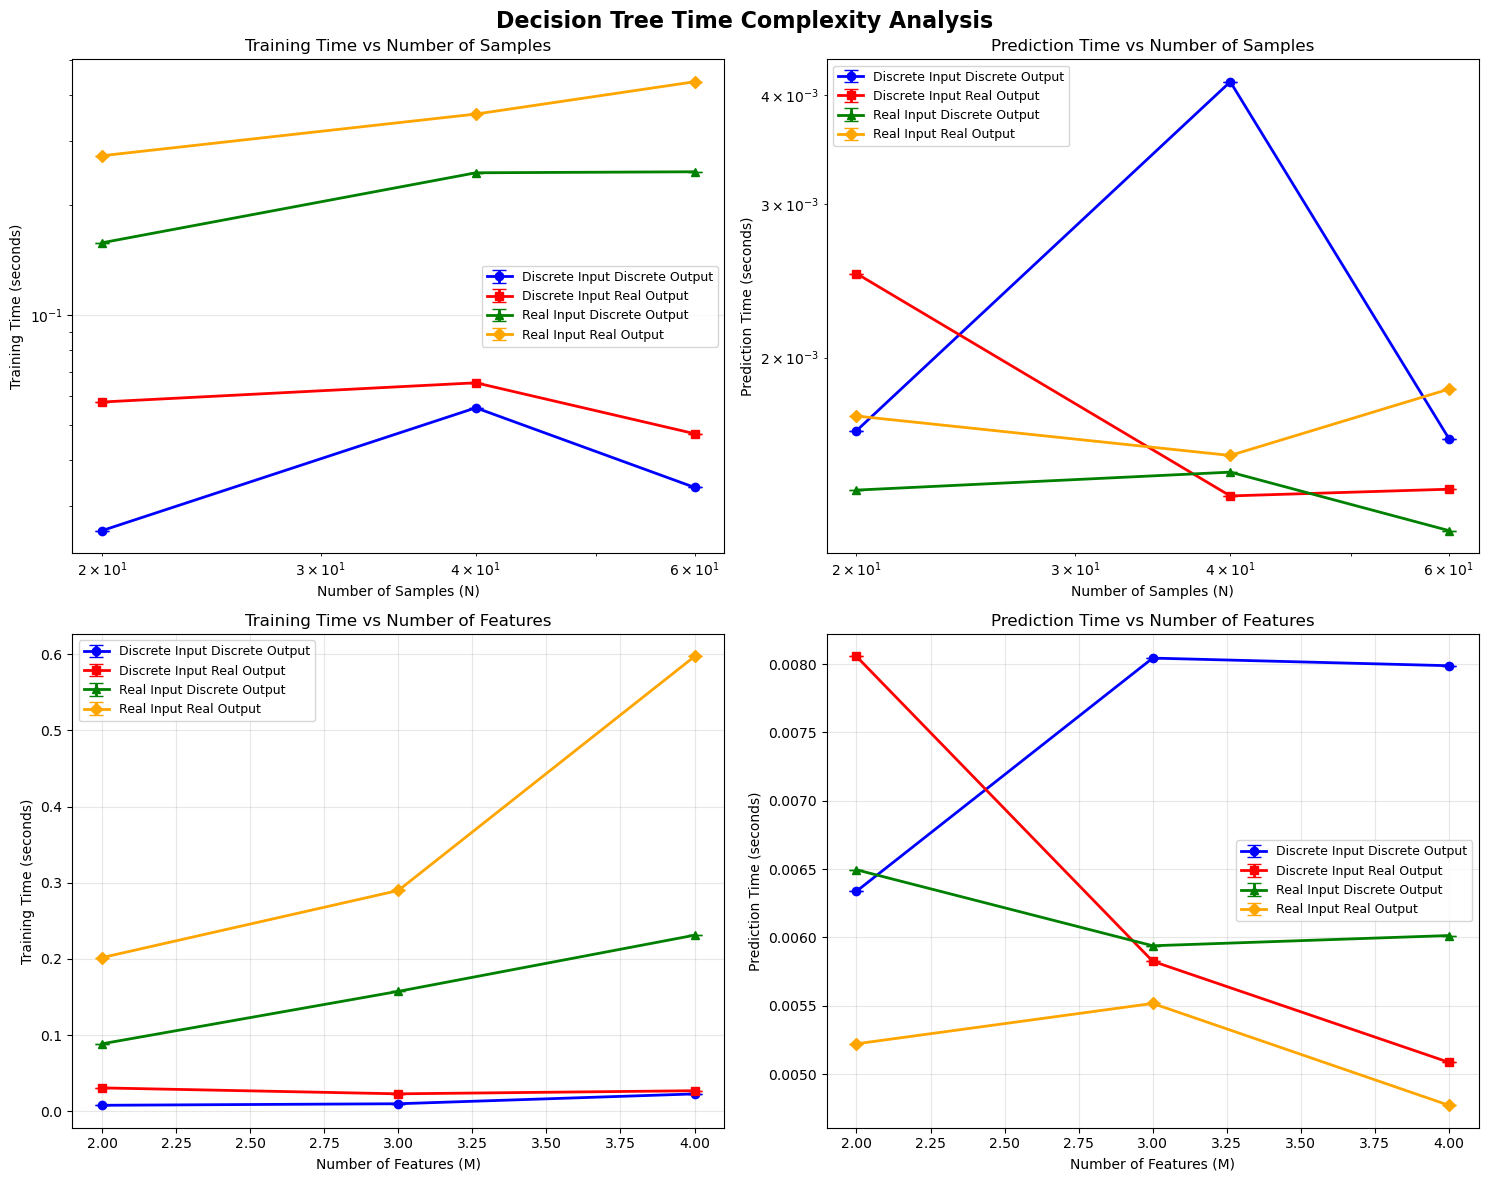

In [12]:
# Generate plots if we have results
if all_results:
    print("\nGENERATING PERFORMANCE PLOTS...")
    plot_complexity_results(all_results, N_values, M_values)
else:
    print("No results to plot. Please run the experiment cells above first.")

In [13]:
# Theoretical complexity analysis
if all_results:
    print("\nTHEORETICAL COMPLEXITY ANALYSIS...")
    analyze_theoretical_complexity(all_results, N_values, M_values)
else:
    print("No results to analyze. Please run the experiment cells above first.")


THEORETICAL COMPLEXITY ANALYSIS...

THEORETICAL COMPLEXITY ANALYSIS

THEORETICAL EXPECTATIONS:
1. Training Time Complexity:
   - Best case: O(N * M * log(N))  [balanced tree]
   - Worst case: O(N * M * N)      [degenerate tree]
   - Average case: O(N * M * log(N))

2. Prediction Time Complexity:
   - Best case: O(log(N))          [balanced tree]
   - Worst case: O(N)              [degenerate tree]
   - Average case: O(log(N))

EMPIRICAL ANALYSIS

Case: DISCRETE_INPUT_DISCRETE_OUTPUT
Training Time Scaling with N:
  Empirical scaling: O(N^0.34)
  Expected: O(N * log(N)) ≈ O(N^1.0 to N^1.3)
Good scaling - close to expected O(N log N)
Prediction Time Scaling with N:
  Empirical scaling: O(N^0.13)
  Expected: O(log(N)) ≈ O(N^0.0 to N^0.3)
Good scaling - close to expected O(log N)
Training Time Scaling with M:
  Empirical scaling: O(M^1.47)
  Expected: O(M) ≈ O(M^1.0)
Good scaling - close to expected O(M)

Case: DISCRETE_INPUT_REAL_OUTPUT
Training Time Scaling with N:
  Empirical scaling: O

## Summary Results Table

In [14]:
# Generate summary table
if all_results:
    print("\nSUMMARY TABLE")
    
    summary_df = pd.DataFrame()
    for case, results in all_results.items():
        summary_df[f"{case}_fit_time"] = results['fit_times_vs_N']
        summary_df[f"{case}_predict_time"] = results['predict_times_vs_N']
    
    summary_df.index = [f"N={n}" for n in N_values]
    print("\nTraining and Prediction Times vs Sample Size:")
    display(summary_df.round(4))
    
    print("\nEXPERIMENTS COMPLETED SUCCESSFULLY!")
else:
    print("No results to summarize. Please run the experiment cells above first.")


SUMMARY TABLE

Training and Prediction Times vs Sample Size:


,discrete_input_discrete_output_fit_time,discrete_input_discrete_output_predict_time,discrete_input_real_output_fit_time,discrete_input_real_output_predict_time,real_input_discrete_output_fit_time,real_input_discrete_output_predict_time,real_input_real_output_fit_time,real_input_real_output_predict_time
N=20,0.0257,0.0016,0.0578,0.0025,0.1577,0.0014,0.2729,0.0017
N=40,0.0557,0.0041,0.0652,0.0014,0.2451,0.0015,0.3549,0.0015
N=60,0.0337,0.0016,0.0473,0.0014,0.2467,0.0013,0.4350,0.0018



EXPERIMENTS COMPLETED SUCCESSFULLY!
